# Initialization

## Importing dependencies

Install the API for eurostat

In [1]:
# Install the Eurostat API wrapper ( the official Python package)
# Allows for easy fetching of datasets like the 'urb_percep' we will be using directly from Eurostat
# Documentation: https://pypi.org/project/eurostat/, we use % as that is what Jupyter uses
%pip install eurostat


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Call imports

In [2]:
import eurostat # loading the Eurostat API wrapper we just installed above, gives access to the commands we will be using
import pandas as pd # self-explanatory
import plotly.graph_objects as go
import geopandas as gpd # map display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

## Declaring functions

### Functions used for the ETL of safety data

In [3]:
def align_on_city_period(df1, df2):
    """
    Align two dataframes by retaining only rows with shared cities\TIME_PERIOD values.

    Parameters
    ----------
    df1 : pd.DataFrame
        First dataframe with a 'cities\TIME_PERIOD' column.
    df2 : pd.DataFrame
        Second dataframe with a 'cities\TIME_PERIOD' column.

    Returns
    -------
    tuple of pd.DataFrame
        Filtered versions of df1 and df2 with matching cities\TIME_PERIOD entries.
    """
    # Find common keys
    common_keys = set(df1["cities\TIME_PERIOD"]).intersection(df2["cities\TIME_PERIOD"])

    # Filter both dataframes
    df1_filtered = df1[df1["cities\TIME_PERIOD"].isin(common_keys)].copy()
    df2_filtered = df2[df2["cities\TIME_PERIOD"].isin(common_keys)].copy()

    return df1_filtered, df2_filtered


In [4]:
def aggregate_by_country(df):
    """
    Aggregate numeric columns by 'Country', removing city-level rows.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least 'City/LAU' and 'Country'.

    Returns
    -------
    pd.DataFrame
        DataFrame with one row per Country and numeric columns averaged.
        Non-numeric columns (except 'Country') are dropped.
    """
    # Defensive copy to protect the original dataframe
    df = df.copy()

    # Drop the city identifier column
    df = df.drop(columns=["City/LAU"])

    # Select numeric columns only (keeps Country for grouping)
    numeric_cols = df.select_dtypes(include="number").columns.tolist()

    # Group by Country and compute mean of numeric columns
    aggregated = df.groupby("Country", as_index=False)[numeric_cols].mean()

    return aggregated


In [5]:
def combine_yearly_data(dfs:list[pd.DataFrame], labels:list[str], year:str):
    """
    Combine values from four datasets for a given year,
    assuming cities\TIME_PERIOD is consistent across all.

    Parameters
    ----------
    dfs : list of pd.DataFrame
        List of four dataframes, each with 'cities\TIME_PERIOD' and year columns.
    labels : list of str
        List of labels to name each value column in the output.        
    year : str
        Year column to extract (e.g., "20XX").

    Returns
    -------
    pd.DataFrame
        A hard copy of the combined dataframe around cities\TIME_PERIOD.
    """

     # Rename each year column to the corresponding label
    renamed = [
        df[["cities\TIME_PERIOD", year]].rename(columns={year: labels[i]}).copy(deep=False)
        for i, df in enumerate(dfs)
    ]

    # Merge all on cities\\TIME_PERIOD
    merged = renamed[0]
    for df in renamed[1:]:
        merged = merged.merge(df, on="cities\TIME_PERIOD", how="inner")

    return merged.copy()


In [6]:
def load_city_key(path="ESTAT_CITIES_3.2.tsv"):
    """
    Read ESTAT_CITIES_3.2.tsv and return a DataFrame keyed by CODE
    containing only the English label.

    Returns
    -------
    pd.DataFrame
        Index: CODE (string)
        Column: Label - English (string)
    """
    # Read TSV, explicitly select columns to avoid loading unnecessary data
    df = pd.read_csv(path, sep="\t", usecols=["CODE", "Label - English"], dtype=str, encoding="utf-8", header=0)

    # Strip whitespace from strings and drop rows with missing CODE or label
    df["CODE"] = df["CODE"].str.strip()
    df["Label - English"] = df["Label - English"].str.strip()
    df = df.dropna(subset=["CODE", "Label - English"])

    # Remove possible duplicate CODEs keeping the first occurrence
    df = df.drop_duplicates(subset=["CODE"], keep="first")

    # Set CODE as the index and return
    df = df.set_index("CODE")
    return df

In [7]:
def filter_by_city_list(df, city_list: list[str]):
    """
    Filter dataframe to include only rows where 'City/FAU' is in the given city list.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with a 'City/FAU' column.
    city_list : list of str
        List of city names to retain.

    Returns
    -------
    pd.DataFrame
        Filtered dataframe with only matching cities.
    """
    return df[df["City/LAU"].isin(city_list)].copy(deep = False)


In [8]:
def filter_by_indicator(code: str, keep_cols: list[str], df):
    """
    Filter full_data by indic_ur code and return only cities\TIME_PERIOD and year columns.

    Parameters
    ----------
    code : str
        The indicator code to filter by (e.g., "PS351#V").
    keep_cols : list[str]
        The columns to keep in the filtered dataframe.
    df : pd.DataFrame
        The full_data dataframe with expected columns.

    Returns
    -------
    pd.DataFrame
        Filtered dataframe with cities\TIME_PERIOD and year columns only.
    """
    
    # Filter rows and return selected columns
    return df[df["indic_ur"] == code][keep_cols].copy(deep=False)


In [9]:
def rate_of_change_agreement(df1, df2):
    """
    Calculate the rate of change in agreement between two dataframes without altering the inputs.

    Parameters
    ----------
    df1 : pd.DataFrame
        First dataframe with multiple 'agree' columns.
    df2 : pd.DataFrame
        Second dataframe with multiple 'agree' columns.

    Returns
    -------
    pd.DataFrame
        A merged dataframe with the change in precieved agreement for each city.
    """
    # Defensive copy to protect the original dataframes
    df1 = df1.copy()
    df2 = df2.copy()

    # Find the totale agreement for each city in both dataframes
    df1["Total Agreement"] = df1["Strongly agree"] + df1["Somewhat agree"]
    df2["Total Agreement"] = df2["Strongly agree"] + df2["Somewhat agree"]

    # Merge the dataframes on cities\TIME_PERIOD
    merged = df1[["Country", "City/LAU", "Total Agreement"]].merge(
        df2[["Country", "City/LAU", "Total Agreement"]],
        on=["Country", "City/LAU"],
        suffixes=("_2019", "_2023")
    )

    # Find the change in percentage
    merged["Change in Agreement"] = merged["Total Agreement_2023"] - merged["Total Agreement_2019"]

    return merged

### Functions used for the maps 

In [10]:
def map_change(df, value_col="Change in Agreement", title="Change in Perceived Urban Safety (2019–2023)"):
    """
    Map of change by country.
    Works whether df['Country'] holds ISO-2 codes (e.g., 'AT') or full names (e.g., 'Austria').
    """

    # Load Natural Earth countries (GeoPandas ≥1.0 no bundled datasets)
    world = gpd.read_file(
        "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    )

    # Column name helpers (handles casing)
    cols = {c.lower(): c for c in world.columns}
    cont_col = cols.get("continent", "CONTINENT")
    iso_col  = cols.get("iso_a2", "ISO_A2")
    # candidate name columns in Natural Earth (varies by version)
    name_cols = [c for c in ["ADMIN", "NAME_EN", "NAME"] if c in world.columns]

    europe = world[world[cont_col] == "Europe"].copy()

    # Decide how to join: codes vs names
    country_vals = df["Country"].astype(str)
    looks_like_iso2 = country_vals.str.match(r"^[A-Z]{2}$").all()

    if looks_like_iso2:
        left_on, right_on = iso_col, "Country"
    else:
        # try to join on the first available name column
        if not name_cols:
            raise KeyError("No country name column found in Natural Earth data.")
        left_on, right_on = name_cols[0], "Country"

    merged = europe.merge(df[[right_on, value_col]], how="left", left_on=left_on, right_on=right_on)

    # Optional: show which countries didn’t match
    missing = (merged[merged[value_col].isna()][left_on]
               .dropna().astype(str).unique().tolist())
    if missing:
        print("No match for:", ", ".join(sorted(missing)))

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    merged.plot(column=value_col, cmap="RdYlGn",
                linewidth=0.6, edgecolor="black",
                legend=True, legend_kwds={"label": "Change in Agreement (%)"},
                ax=ax,
                vmin=-10, vmax=10   # makes gradient steeper + focused
                )

    # Zoom in on Europe (bounding box)
    ax.set_xlim(-10, 35)   # longitude range
    ax.set_ylim(35, 72)    # latitude range


    ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")
    plt.show()


In [11]:
def map_current(df, value_col="Total Agreement_2023", 
                title="Perceived Urban Safety — 2023"):
    """
    Map current safety agreement levels by country.
    Uses the same structure as map_change but with a sequential colormap.
    """

    world = gpd.read_file(
        "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    )

    cols = {c.lower(): c for c in world.columns}
    cont_col = cols.get("continent", "CONTINENT")
    iso_col  = cols.get("iso_a2", "ISO_A2")
    name_cols = [c for c in ["ADMIN", "NAME_EN", "NAME"] if c in world.columns]

    europe = world[world[cont_col] == "Europe"].copy()

    looks_like_iso2 = df["Country"].astype(str).str.match(r"^[A-Z]{2}$").all()
    if looks_like_iso2:
        left_on, right_on = iso_col, "Country"
    else:
        left_on, right_on = name_cols[0], "Country"

    merged = europe.merge(df[[right_on, value_col]], how="left",
                          left_on=left_on, right_on=right_on)

    plt.figure(figsize=(9, 7))
    ax = plt.gca()

    #  Sequential green palette for current safety levels
    merged.plot(
        column=value_col,
        cmap="RdYlGn",
        linewidth=0.6,
        edgecolor="black",
        legend=True,
        legend_kwds={"label": f"{value_col} (%)"},
        ax=ax,
        vmin=60, vmax=95  #  fixed range for consistent interpretation
    )

    ax.set_xlim(-10, 35)
    ax.set_ylim(35, 72)
    ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")
    plt.show()


### Functions used for tourism cross reference data

In [12]:
def load_tourism_annual_wide(path, years=(2019, 2023)):
    """
    Parse Eurostat 'tour_occ' wide TSV where col0 is '...geo\\TIME_PERIOD'
    and month columns look like '2019-01 ' etc. Returns one row per ISO-2 'geo':
    ['geo', 'Nights_<year>', ...]
    """
    df = pd.read_csv(path, sep="\t", dtype=str, na_values=":")

    # Strip BOM + whitespace from column names (your file has trailing spaces)
    clean_cols = [c.encode('utf-8').decode('utf-8').strip() for c in df.columns]
    df.columns = clean_cols

    # First column packs dims + '\TIME_PERIOD'
    key_col = df.columns[0]
    left = df[key_col].astype(str).str.split("\\", n=1).str[0]
    df["geo"] = left.str.split(",").str[-1].str.strip()

    # Month columns like 2019-01, 2023-12 (after stripping)
    month_cols = [c for c in df.columns if re.fullmatch(r"\d{4}-\d{2}", c) or re.fullmatch(r"\d{4}M\d{2}", c)]
    if not month_cols:
        raise ValueError("No monthly columns found after cleaning headers.")

    # Convert month cells to numeric (strip flags like ' e', ' c')
    def _to_num(s):
        return pd.to_numeric(pd.Series(s).astype(str).str.extract(r"([\-0-9\.]+)")[0], errors="coerce")
    df[month_cols] = df[month_cols].apply(_to_num, axis=0)

    # Sum months for each requested year
    out = df[["geo"]].copy()
    for y in years:
        ycols = [c for c in month_cols if c.startswith(str(y))]
        out[f"Nights_{y}"] = df[ycols].sum(axis=1)

    # Collapse any duplicates from other dims -> one row per geo
    out = out.groupby("geo", as_index=False)[[f"Nights_{y}" for y in years]].sum()
    return out

In [13]:
def prepare_tourism_change(annual_df):
    """
    Map ISO-2 -> country names and compute % change (2023 vs 2019).
    Returns: ['Country','Nights_2019','Nights_2023','Tourism Δ (%)']
    """
    world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
    iso_col  = "ISO_A2" if "ISO_A2" in world.columns else "iso_a2"
    name_col = "ADMIN" if "ADMIN" in world.columns else "NAME"
    iso_to_name = dict(zip(world[iso_col], world[name_col]))

    out = annual_df.copy()
    out["Country"] = out["geo"].map(iso_to_name)
    out = out.dropna(subset=["Country", "Nights_2019", "Nights_2023"])

    out["Tourism Δ (%)"] = (out["Nights_2023"] - out["Nights_2019"]) / out["Nights_2019"] * 100
    return out[["Country", "Nights_2019", "Nights_2023", "Tourism Δ (%)"]]

### Functions used for plots

In [14]:
def plot_city_extremes(df, n=10):
    # pick top/bottom movers
    top = df.nlargest(n, "Change in Agreement")
    bottom = df.nsmallest(n, "Change in Agreement")
    sample = pd.concat([top, bottom]).copy()
    # nicer label
    sample["City label"] = sample["City/LAU"] + " — " + sample["Country"]

    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=sample.sort_values("Change in Agreement"),
        x="Change in Agreement", y="City label", hue="Country", dodge=False
    )
    plt.axvline(0, color="gray", ls="--", lw=1)
    plt.title("Cities with the Biggest Shifts in Perceived Safety (2019→2023)")
    plt.xlabel("Change in Agreement (%)")
    plt.ylabel("")
    plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [15]:
def plot_city_vs_country(
    df,
    city_col="City/LAU",
    country_col="Country",
    value_col="Change in Agreement",
    annotate=10,        # how many largest outliers to label (abs deviation)
    figsize=(8, 6),
):
    """
    Scatter: city change vs country average change.
    Points above the diagonal improved more than their country's average; below = worse.
    Returns the dataframe with country averages and deviation, sorted by |deviation|.
    """
    # country average change
    country_avg = (df.groupby(country_col, as_index=False)[value_col]
                     .mean()
                     .rename(columns={value_col: "Country Δ"}))

    # join back to cities + deviation from country trend
    data = df.merge(country_avg, on=country_col, how="left").copy()
    data["Deviation"] = data[value_col] - data["Country Δ"]

    # figure
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(
        data=data, x="Country Δ", y=value_col, hue=country_col, legend=False, s=50
    )

    # 45° line (city == country)
    m = min(data["Country Δ"].min(), data[value_col].min())
    M = max(data["Country Δ"].max(), data[value_col].max())
    ax.plot([m, M], [m, M], color="gray", ls="--", lw=1)

    # label top outliers by |Deviation|
    if annotate and annotate > 0:
        lab = data.reindex(data["Deviation"].abs().nlargest(annotate).index)
        for _, r in lab.iterrows():
            ax.text(r["Country Δ"], r[value_col], f" {r[city_col]}", va="center", fontsize=9)

    ax.set_title("City Change vs Country Average (2019→2023)")
    ax.set_xlabel("Country average change (%)")
    ax.set_ylabel("City change (%)")
    plt.tight_layout()
    plt.show()

    return data.sort_values("Deviation", key=lambda s: s.abs(), ascending=False)

In [16]:
def plot_dumbbell_agreement(df,
                            category_col,
                            left_col="Total Agreement_2019",
                            right_col="Total Agreement_2023",
                            left_color="#FF8C42",   # orange tone
                            right_color="#1F77B4",  # blue (plotly default-ish)
                            increase_color="#2CA02C",# green for increases
                            decrease_color="#D62728",# red for decreases
                            marker_size=10,
                            figsize_height_per_row=30):
    """
    Draw a horizontal dumbbell plot with Plotly showing left_col -> right_col per category.
    - df: pandas DataFrame
    - category_col: column name with category labels (y-axis)
    - left_col, right_col: numeric columns to compare
    Returns: plotly.graph_objects.Figure
    """
    # Defensive copy to protect the original dataframe of only the important information
    plot_df = df[[category_col, left_col, right_col]].copy()

    # Sort descending by left_col so highest 2019 at top
    plot_df = plot_df.sort_values(by=left_col, ascending=False).reset_index(drop=True)
    categories = plot_df[category_col].astype(str).tolist()

    fig = go.Figure()

    # Add connecting lines as separate traces so we can color by direction
    for i, row in plot_df.iterrows():
        x0 = row[left_col]; x1 = row[right_col]; y = row[category_col]
        line_color = increase_color if x1 > x0 else (decrease_color if x1 < x0 else "gray")
        fig.add_trace(go.Scatter(
            x=[x0, x1],
            y=[y, y],
            mode="markers+lines",
            marker=dict(symbol="arrow", color=line_color, size=marker_size, angleref="previous", standoff=8),
            line=dict(color=line_color, width=2),
            showlegend=False,
            hoverinfo="none"  # markers will carry hover info
        ))

    # left markers (2019)
    fig.add_trace(go.Scatter(
        x=plot_df[left_col],
        y=plot_df[category_col],
        mode="markers",
        name=left_col,
        marker=dict(color=left_color, size=marker_size, line=dict(color="black", width=0.5)),
        hovertemplate=f"{category_col}: %{{y}}<br>{left_col}: %{{x}}<extra></extra>"
    ))

    # right markers (2023)
    fig.add_trace(go.Scatter(
        x=plot_df[right_col],
        y=plot_df[category_col],
        mode="markers",
        name=right_col,
        marker=dict(color=right_color, size=marker_size, line=dict(color="black", width=0.5)),
        hovertemplate=f"{category_col}: %{{y}}<br>{right_col}: %{{x}}<extra></extra>"
    ))

    # Here we add invisible small scatter for legend clarity and layout settings
    fig.update_layout(
        xaxis_title="Total Agreement",
        yaxis=dict(autorange="reversed"),  # keep highest at the top
        template="simple_white",
        height=max(400, figsize_height_per_row * len(plot_df)),
        legend=dict(title="", orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Add annotations showing delta and color-coded sign
    deltas = plot_df[right_col] - plot_df[left_col]
    for i, (cat, left_val, right_val, delta) in enumerate(zip(plot_df[category_col], plot_df[left_col], plot_df[right_col], deltas)):
        sign = "+" if delta > 0 else ("-" if delta < 0 else "")
        color = increase_color if delta > 0 else (decrease_color if delta < 0 else "gray")
        fig.add_annotation(
            x=max(left_val, right_val) + (0.02 * (fig.layout.xaxis.range[1] if fig.layout.xaxis.range else max(plot_df[right_col].max(), plot_df[left_col].max()))),
            y=cat,
            text=f"{sign}{delta:.2f}",
            showarrow=False,
            font=dict(color=color),
            yshift=0
        )

    # If x-axis range not set, make a comfortable padding
    x_max = max(plot_df[right_col].max(), plot_df[left_col].max())
    x_min = min(plot_df[right_col].min(), plot_df[left_col].min())
    padding = (x_max - x_min) * 0.08 if (x_max - x_min) > 0 else 1
    fig.update_xaxes(range=[max(0, x_min - padding), x_max + padding])

    return fig

In [17]:
def plot_extremes_vs_country(df, n=10):
    """
    Compare extreme city changes to their country's average trend.
    Shows how top and bottom movers deviate from national averages.
    """
    # calculate country-level mean
    country_avg = (df.groupby("Country", as_index=False)["Change in Agreement"]
                     .mean()
                     .rename(columns={"Change in Agreement": "Country Avg"}))
    
    # merge back to get deviation
    merged = df.merge(country_avg, on="Country", how="left")
    merged["Deviation"] = merged["Change in Agreement"] - merged["Country Avg"]

    # select biggest outliers (both directions)
    top = merged.nlargest(n, "Deviation")
    bottom = merged.nsmallest(n, "Deviation")
    extremes = pd.concat([top, bottom])
    extremes["City label"] = extremes["City/LAU"] + " — " + extremes["Country"]

    # plot
    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=extremes.sort_values("Deviation"),
        x="Deviation", y="City label", hue="Country", dodge=False
    )
    plt.axvline(0, color="gray", ls="--", lw=1)
    plt.title("Extreme City Deviations from Country Trend (2019→2023)")
    plt.xlabel("Deviation from Country Average (%)")
    plt.ylabel("")
    plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return extremes[["Country", "City/LAU", "Change in Agreement", "Country Avg", "Deviation"]]

In [18]:
def plot_safety_residuals(merged, x_col="Tourism Δ (%)", y_col="Change in Agreement"):
    """
    Visualize how each country's perceived safety deviated from the expected trend given tourism change.
    Fits: Change in Agreement = a * Tourism Δ + b
    """
    df = merged.copy()
    df[x_col] = pd.to_numeric(df[x_col], errors="coerce")
    df[y_col] = pd.to_numeric(df[y_col], errors="coerce")
    mask = np.isfinite(df[x_col]) & np.isfinite(df[y_col])
    fit = df.loc[mask, ["Country", x_col, y_col]].copy()

    if len(fit) < 3:
        raise ValueError(f"Not enough valid rows (have {len(fit)}).")

    # Linear fit: y = a*x + b
    a, b = np.polyfit(fit[x_col].to_numpy(), fit[y_col].to_numpy(), 1)
    print(f"slope={a:.3f}, intercept={b:.3f}, n={len(fit)}")

    fit["Predicted_Safety"] = a * fit[x_col] + b
    fit["Residual"] = fit[y_col] - fit["Predicted_Safety"]
    fit["AbsResidual"] = fit["Residual"].abs()
    fit_sorted = fit.sort_values("AbsResidual", ascending=False)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=fit_sorted,
        y="Country",
        x="Residual",
        hue=np.where(fit_sorted["Residual"] > 0, "Above trend", "Below trend"),
        dodge=False,
        palette={"Above trend": "green", "Below trend": "red"},
    )
    plt.axvline(0, color="gray", lw=1, ls="--")
    plt.title("Perceived Safety vs Tourism: Countries Above/Below Expected Trend (2019→2023)")
    plt.xlabel("Residual (Actual − Predicted Safety Change %)")
    plt.ylabel("")
    plt.legend(title="Trend position")
    plt.tight_layout()
    plt.show()

    return fit_sorted.drop(columns="AbsResidual")[["Country", x_col, y_col, "Predicted_Safety", "Residual"]]


In [19]:
def plot_safety_vs_tourism(country_change, tourism_change):
    """
    Merge safety change with tourism % change and plot a scatter + trendline.
    Expects:
      country_change: ['Country', 'Change in Agreement']
      tourism_change: ['Country', 'Tourism Δ (%)']
    """
    merged = country_change.merge(
        tourism_change[['Country', 'Tourism Δ (%)']],
        on='Country', how='inner'
    ).dropna(subset=['Tourism Δ (%)', 'Change in Agreement'])

    plt.figure(figsize=(8, 6))
    sns.regplot(
        data=merged,
        x='Change in Agreement', y='Tourism Δ (%)',
        scatter_kws={'s': 70}, ci=None, color='teal'
    )

    plt.title('Perceived Safety Change vs Tourism Growth (2019→2023)')
    plt.xlabel('Change in Perceived Safety Agreement (%)')
    plt.ylabel('Change in Tourism Nights (%)')
    plt.axhline(0, color='gray', lw=1, ls='--')
    plt.axvline(0, color='gray', lw=1, ls='--')
    plt.tight_layout()
    plt.show()

    corr = merged[['Change in Agreement', 'Tourism Δ (%)']].corr().iloc[0, 1]
    print(f"Pearson correlation: {corr:.2f}  (n={len(merged)})")

    return merged

In [20]:
def plot_safety_vs_tourism_scatter(
    merged,
    x_col="Tourism Δ (%)",
    y_col="Change in Agreement",
    label_top_n=10
):
    df = merged.copy()
    df[x_col] = pd.to_numeric(df[x_col], errors="coerce")
    df[y_col] = pd.to_numeric(df[y_col], errors="coerce")
    df = df.dropna(subset=[x_col, y_col, "Country"]).reset_index(drop=True)

    # Remove infinities just in case
    df = df[np.isfinite(df[x_col]) & np.isfinite(df[y_col])]
    print(f"✅ Cleaned dataset: {len(df)} rows")
    print(df[[x_col, y_col]].describe())

    if df.empty or df[x_col].nunique() < 3:
        raise ValueError("Not enough valid numeric data for regression.")

    # Compute slope and intercept manually (OLS)
    x = df[x_col].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    var_x = np.mean((x - x_mean) ** 2)
    cov_xy = np.mean((x - x_mean) * (y - y_mean))

    if np.isfinite(var_x) and var_x != 0:
        a = cov_xy / var_x
        b = y_mean - a * x_mean
    else:
        raise ValueError("Invalid data variance (check x values).")

    print(f"slope = {a:.4f}, intercept = {b:.4f}, n = {len(df)}")

    # Predictions + residuals
    df["Predicted_Safety"] = a * df[x_col] + b
    df["Residual"] = df[y_col] - df["Predicted_Safety"]
    df["Trend"] = np.where(df["Residual"] > 0, "Above trend", "Below trend")

    label_idx = df["Residual"].abs().nlargest(label_top_n).index

    # Plot
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue="Trend",
        palette={"Above trend": "green", "Below trend": "red"},
        s=80,
        edgecolor="black",
        alpha=0.9,
    )

    # Regression line
    x_vals = np.linspace(df[x_col].min(), df[x_col].max(), 100)
    plt.plot(x_vals, a * x_vals + b, color="gray", lw=2, ls="--", label="Regression line")

    # Label key countries
    for _, r in df.loc[label_idx].iterrows():
        plt.text(r[x_col] + 0.3, r[y_col], r["Country"], fontsize=8, alpha=0.85)

    plt.axhline(0, color="lightgray", lw=1)
    plt.axvline(0, color="lightgray", lw=1)
    plt.title("Perceived Safety vs Tourism Change (2019→2023)")
    plt.xlabel("Tourism Change (% in nights)")
    plt.ylabel("Change in Perceived Safety Agreement (%)")
    plt.legend(title="Relative to regression")
    plt.tight_layout()
    plt.show()

    return df[["Country", x_col, y_col, "Predicted_Safety", "Residual"]]


> End of of initialization

<hr>

# Main: Data presentation

This Notebook serves as a script to collect to later analyze data from the Eurostat database. The findings for this notebook will be culminated in the google slide that you can find in the following link: SLIDE LINK

## Staging the dataset

- [x] Define dataset to get

- [x] Get the dataset as a pandas dataframe

- [x] Remove any unnecessary information

- [x] Test for dirty data (make the variables consistente and clear NAN)

- [x] Refactor the dataset to only hold what we are interested in

- [x] Update the dataframe to have readable names

### Extracting Eurostat data for urban perception survey

We will use data from the urban perception surveys done throughout European cities. Particularly, the data for the question: I feel safe walking alone at night? 

First step for this is to import the urban perception dataset and figure out how the data is returned by the API:

In [21]:
full_data = eurostat.get_data_df('urb_percep')
print(full_data.shape)

full_data.head(10)

(39835, 11)


,freq,indic_ur,unit,cities\TIME_PERIOD,2004,2006,2009,2012,2015,2019,2023
0,A,PS1012V,PC,AT001C,48.0,63.4,53.1,60.0,72.0,70.0,63.5
1,A,PS1012V,PC,AT002C,NaN,25.2,28.2,28.0,39.0,35.0,37.5
2,A,PS1012V,PC,BE001C,22.0,24.7,17.8,22.0,19.0,18.5,23.2
3,A,PS1012V,PC,BE002C,32.0,38.8,38.3,21.0,24.0,23.4,22.3
4,A,PS1012V,PC,BE005C,25.0,31.5,16.9,18.0,14.0,14.7,15.7
5,A,PS1012V,PC,BG001C,NaN,5.6,8.8,19.0,18.0,17.2,20.7
6,A,PS1012V,PC,BG004C,NaN,19.8,19.0,21.0,53.0,49.3,44.3
7,A,PS1012V,PC,CH002C,NaN,NaN,NaN,22.0,36.0,78.2,76.0
8,A,PS1012V,PC,CH003C,NaN,NaN,NaN,NaN,NaN,35.6,36.4
9,A,PS1012V,PC,CY001C,NaN,7.7,4.4,23.0,14.0,12.8,11.9


Given that the data uses an ID for referring to individual cities and LAUs, we shall request from the API a list of the description of the column headers to be able to collect a key for the "cities":

In [22]:
eurostat.get_dic('urb_percep')

[('freq',
  'Time frequency',
  'This code list contains the periodicity that refers to the frequency.'),
 ('indic_ur',
  'Urban audit indicator',
  'This code list defines different type of urban audit indicators.'),
 ('unit', 'Unit of measure', None),
 ('cities',
  'Geopolitical entity (declaring)',
  'This code list contains all reporting cities. A city is a local administrative unit (LAU) where at least 50 % of the population lives in one or more urban centres.')]

The description calls for a key that is called CITIES. This is a code list that is used as a standard form for multiple datasets inside the Eurostat database. With this, a dataframe will be made by downloading the TSV file that is provided from the database.

In [23]:
load_city_key().head(10)

,Label - English
CODE,
BE,Belgium
BE001C,Bruxelles/Brussel (greater city)
BE001F,Bruxelles/Brussel/Leuven
BE002C,Antwerpen (greater city)
BE002F,Antwerpen
BE003C,Gent
BE003F,Gent
BE004C,Charleroi (greater city)
BE004F,Charleroi


### Isolating the points of interest

As can be seen, this dataset normalized all the results of the urban perception survey. This means that to get the results to the specific question we are looking for, we need to isolate those IDs in specific. These IDs also come from a code list like the cities key, but since we are only evaluating 5 specific entries, it is fine to just look it up.

To the right, the table with the corresponding IDs. Each ID represents the percentage of the population of a specific LAU that answers between strongly agree and strongly disagree to the question "I feel safe walking alone at night in my city".

| Answer            | ID      |
|-------------------|---------|
| Strongly agree    | PS3514V |
| Somewhat agree    | PS3515V |
| Somewhat disagree | PS3516V |
| Strongly disagree | PS3517V |

For better clarification, let us make dedicated dataframe masks to each answer, starting with strongly agree to see how it looks:

In [24]:
# Define the answer IDs and their corresponding meanings
answer_ids = {
    "Strongly agree": "PS3514V",
    "Somewhat agree": "PS3515V",
    "Somewhat disagree": "PS3516V",
    "Strongly disagree": "PS3517V"
}

# Define columns to keep
keep_cols = ["cities\TIME_PERIOD", "2004", "2006", "2009", "2012", "2015", "2019", "2023"]

# Doing a quick test to see how the dataframe looks like:
filter_by_indicator(answer_ids["Strongly agree"], keep_cols, full_data).head(10)

,cities\TIME_PERIOD,2004,2006,2009,2012,2015,2019,2023
26923,AT001C,NaN,NaN,NaN,NaN,NaN,49.2,39.7
26924,AT002C,NaN,NaN,NaN,NaN,NaN,41.5,36.0
26925,BE001C,NaN,NaN,NaN,NaN,NaN,14.7,14.4
26926,BE002C,NaN,NaN,NaN,NaN,NaN,24.3,30.7
26927,BE005C,NaN,NaN,NaN,NaN,NaN,8.2,8.4
26928,BG001C,NaN,NaN,NaN,NaN,NaN,9.4,15.3
26929,BG004C,NaN,NaN,NaN,NaN,NaN,20.1,19.7
26930,CH002C,NaN,NaN,NaN,NaN,NaN,51.4,46.7
26931,CH003C,NaN,NaN,NaN,NaN,NaN,23.8,25.3
26932,CY001C,NaN,NaN,NaN,NaN,NaN,26.1,33.3


From this test, it is possible to see that only the data for 2019 and 2023 has answers for that question, so all the rest of the columns can also be ignored.

In [25]:
# Redefine columns to keep
keep_cols = ["cities\TIME_PERIOD", "2019", "2023"]

# Making the collection of answers for each question:
answers_dfs = [
    filter_by_indicator(answer_ids["Strongly agree"], keep_cols, full_data),
    filter_by_indicator(answer_ids["Somewhat agree"], keep_cols, full_data),
    filter_by_indicator(answer_ids["Somewhat disagree"], keep_cols, full_data),
    filter_by_indicator(answer_ids["Strongly disagree"], keep_cols, full_data)
]
answers_dfs[0].head(10)

,cities\TIME_PERIOD,2019,2023
26923,AT001C,49.2,39.7
26924,AT002C,41.5,36.0
26925,BE001C,14.7,14.4
26926,BE002C,24.3,30.7
26927,BE005C,8.2,8.4
26928,BG001C,9.4,15.3
26929,BG004C,20.1,19.7
26930,CH002C,51.4,46.7
26931,CH003C,23.8,25.3
26932,CY001C,26.1,33.3


The last thing to make sure that we have what we are working for is collecting the answers into a single entry per year, so we can compare them time wise:

In [26]:
answers_2019 = combine_yearly_data(answers_dfs, list(answer_ids.keys()), "2019")
answers_2023 = combine_yearly_data(answers_dfs, list(answer_ids.keys()), "2023")

answers_2019.head(10)

,cities\TIME_PERIOD,Strongly agree,Somewhat agree,Somewhat disagree,Strongly disagree
0,AT001C,49.2,32.1,14.0,3.6
1,AT002C,41.5,38.2,14.7,3.6
2,BE001C,14.7,43.2,25.9,13.7
3,BE002C,24.3,46.8,20.3,7.3
4,BE005C,8.2,34.8,33.7,21.5
5,BG001C,9.4,30.7,26.8,30.4
6,BG004C,20.1,50.5,15.8,10.7
7,CH002C,51.4,37.7,7.3,1.5
8,CH003C,23.8,52.9,13.3,4.2
9,CY001C,26.1,43.6,17.5,11.5


In [27]:
# Cleaning up no longer necessary variables

del keep_cols
del answer_ids
del answers_dfs
del full_data

### Removing unnecessary entries and possible errors

For practicality, we will also run pandas default NaN remover in case any exist

In [28]:
answers_2019 = answers_2019.dropna(how="any")
answers_2023 = answers_2023.dropna(how="any")

# Testing if they are still the same size
if answers_2019.shape[0] == answers_2023.shape[0]:
    print("Both dataframes have the same number of rows.")
else:
    print("The dataframes have different numbers of rows.")

The dataframes have different numbers of rows.


Since it happens that both the answers for 2019 and 2023 have different places with NaNs it means the entries are no longer alligned, so we must correct that by dropping the entries that are not present in both dfs

In [29]:
answers_2019, answers_2023 = align_on_city_period(answers_2019, answers_2023)

### Transforming the dataframes

A final makeup needs to be done to make sure that the data is good to be read for humans in a table (by making the cities no longer in a code format) using the aforementioned key, and given that the key also holds information regarding which country every city is from, that will also be added to the dataframe.

In [30]:
temp_citykey = load_city_key()

# Adding a Country column for identiffication
answers_2019["Country"] = answers_2019["cities\TIME_PERIOD"].str[:2]
answers_2023["Country"] = answers_2023["cities\TIME_PERIOD"].str[:2]

# Map the city codes to their English labels
answers_2019["cities\TIME_PERIOD"] = answers_2019["cities\TIME_PERIOD"].map(temp_citykey["Label - English"])
answers_2023["cities\TIME_PERIOD"] = answers_2023["cities\TIME_PERIOD"].map(temp_citykey["Label - English"])

# Map the country codes to their English labels
answers_2019["Country"] = answers_2019["Country"].map(temp_citykey["Label - English"])
answers_2023["Country"] = answers_2023["Country"].map(temp_citykey["Label - English"])

# Rename the column to "City/FUA"
answers_2019 = answers_2019.rename(columns={"cities\TIME_PERIOD": "City/LAU"})
answers_2023 = answers_2023.rename(columns={"cities\TIME_PERIOD": "City/LAU"})

# Drop the city key
del temp_citykey

The data should now be ready to be loaded into the visualizations and analysis done ahead.

## Analysis of tendencies per city

### Raw tables:

Below we have the two processed tables with the data for the urban perception survey, specifically for the percentage of total answers for each city between strongly agree, somewhat agree, somewhat disagree, and strongly disagree for the question do you feel safe walking alone at night in your city?

In [31]:
answers_2019

,City/LAU,Strongly agree,Somewhat agree,Somewhat disagree,Strongly disagree,Country
0,Wien (greater city),49.2,32.1,14.0,3.6,Austria
1,Graz,41.5,38.2,14.7,3.6,Austria
2,Bruxelles/Brussel (greater city),14.7,43.2,25.9,13.7,Belgium
3,Antwerpen (greater city),24.3,46.8,20.3,7.3,Belgium
4,Liège (greater city),8.2,34.8,33.7,21.5,Belgium
...,...,...,...,...,...,...
98,Istanbul,14.7,35.0,18.7,30.8,Türkiye
99,London,29.0,46.7,15.1,7.2,United Kingdom
100,Glasgow,38.6,44.2,10.2,3.8,United Kingdom
102,Cardiff,44.0,34.1,12.2,5.8,United Kingdom


In [32]:
answers_2023

,City/LAU,Strongly agree,Somewhat agree,Somewhat disagree,Strongly disagree,Country
0,Wien (greater city),39.7,37.1,15.5,6.7,Austria
1,Graz,36.0,37.3,19.0,5.8,Austria
2,Bruxelles/Brussel (greater city),14.4,44.2,24.8,14.7,Belgium
3,Antwerpen (greater city),30.7,40.8,18.3,8.6,Belgium
4,Liège (greater city),8.4,34.5,34.1,21.6,Belgium
...,...,...,...,...,...,...
98,Istanbul,17.5,26.2,16.5,39.6,Türkiye
99,London,19.2,39.3,26.1,12.7,United Kingdom
100,Glasgow,24.1,44.0,19.8,9.2,United Kingdom
102,Cardiff,37.6,32.2,17.5,9.5,United Kingdom


### Tendency tables

The data that was collected has the potential to shed light in some possible shifts in perceived safety. This could be indicated by a collection of total agreement. A sum of strong agree and somewhat agree data that would be indicative of people that otherwise do not inherently feel at risk while walking alone at night. Let us find the cities with most curious values: highest and lowest total agreement for 2019 and 2023 and the largest positive and largest negative change.

In [33]:
percieved_safety = rate_of_change_agreement(answers_2019, answers_2023)
percieved_safety.sort_values("Total Agreement_2019", ascending=False).head(5)

,Country,City/LAU,Total Agreement_2019,Total Agreement_2023,Change in Agreement
20,Denmark,København (greater city),93.4,86.5,-6.9
21,Denmark,Aalborg,92.2,83.3,-8.9
28,Spain,Oviedo,90.9,85.3,-5.6
64,Sweden,Stockholm (greater city),90.6,81.4,-9.2
58,Poland,Białystok,90.0,83.5,-6.5


In [34]:
percieved_safety.sort_values("Total Agreement_2019", ascending=True).head(5)

,Country,City/LAU,Total Agreement_2019,Total Agreement_2023,Change in Agreement
23,Greece,Athina (greater city),37.5,40.0,2.5
41,Italy,Roma,38.9,36.8,-2.1
5,Bulgaria,Sofia,40.1,47.7,7.6
4,Belgium,Liège (greater city),43.0,42.9,-0.1
32,France,Marseille (greater city),45.8,42.3,-3.5


In [35]:
percieved_safety.sort_values("Total Agreement_2023", ascending=False).head(5)

,Country,City/LAU,Total Agreement_2019,Total Agreement_2023,Change in Agreement
20,Denmark,København (greater city),93.4,86.5,-6.9
28,Spain,Oviedo,90.9,85.3,-5.6
66,Slovenia,Ljubljana,89.3,85.2,-4.1
7,Switzerland,Zurich (greater city),89.1,84.2,-4.9
52,Netherlands,Groningen,88.6,83.9,-4.7


In [36]:
percieved_safety.sort_values("Total Agreement_2023", ascending=True).head(5)

,Country,City/LAU,Total Agreement_2019,Total Agreement_2023,Change in Agreement
41,Italy,Roma,38.9,36.8,-2.1
23,Greece,Athina (greater city),37.5,40.0,2.5
32,France,Marseille (greater city),45.8,42.3,-3.5
42,Italy,Napoli (greater city),49.9,42.6,-7.3
4,Belgium,Liège (greater city),43.0,42.9,-0.1


In [37]:
percieved_safety.sort_values("Change in Agreement", ascending=False).head(5)

,Country,City/LAU,Total Agreement_2019,Total Agreement_2023,Change in Agreement
5,Bulgaria,Sofia,40.1,47.7,7.6
70,Türkiye,Antalya,73.4,79.4,6.0
49,Latvia,Rīga,66.1,70.0,3.9
23,Greece,Athina (greater city),37.5,40.0,2.5
16,Germany,Stuttgart,61.3,63.3,2.0


In [38]:
percieved_safety.sort_values("Change in Agreement", ascending=True).head(5)

,Country,City/LAU,Total Agreement_2019,Total Agreement_2023,Change in Agreement
73,United Kingdom,London,75.7,58.5,-17.2
76,United Kingdom,Belfast,83.1,66.6,-16.5
74,United Kingdom,Glasgow,82.8,68.1,-14.7
33,France,Bordeaux (greater city),79.4,65.1,-14.3
15,Germany,Essen,77.6,65.3,-12.3


From looking at the data, it was found that some of the more interesting places to keep an eye for are København for having the highest perceived safety both in 2019 and in 2023, Athina and Roma for having the lowest perceived safety in 2019 and 2023 respectively, and Sofia for having the largest improvement in perceived safety and London for the worst decline. 

In [39]:
curious_cities = [
    "København (greater city)",
	"Athina (greater city)",
	"Roma",
	"Sofia",
	"London"]

filter_by_city_list(answers_2019, curious_cities)

,City/LAU,Strongly agree,Somewhat agree,Somewhat disagree,Strongly disagree,Country
5,Sofia,9.4,30.7,26.8,30.4,Bulgaria
43,København (greater city),49.2,44.2,4.3,2.0,Denmark
48,Athina (greater city),8.5,29.0,26.5,34.7,Greece
67,Roma,8.2,30.7,32.1,25.2,Italy
99,London,29.0,46.7,15.1,7.2,United Kingdom


In [40]:
filter_by_city_list(answers_2023, curious_cities)

,City/LAU,Strongly agree,Somewhat agree,Somewhat disagree,Strongly disagree,Country
5,Sofia,15.3,32.4,27.3,24.1,Bulgaria
43,København (greater city),46.7,39.8,8.8,3.7,Denmark
48,Athina (greater city),10.7,29.3,24.0,35.3,Greece
67,Roma,7.2,29.6,31.3,29.8,Italy
99,London,19.2,39.3,26.1,12.7,United Kingdom


It was also noticeable that the positive changes were much more conservative throughout the cities in Europe than the negative changes:

In [41]:
percieved_safety.mean(numeric_only=True)

Total Agreement_2019    72.676623
Total Agreement_2023    67.857143
Change in Agreement     -4.819481
dtype: float64

By calculating the mean across the perceived safety through European cities, it is noticeable that there is a total effective drop. More nuance can be investigated through visualizing this data

### Visualizations

In [42]:
_dntk.DeepnoteChart(percieved_safety, """{"layer":[{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#F9732C","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"nominal","field":"City/LAU","scale":{"type":"linear"}},"y":{"axis":{"title":"Percantage of people feeling safe","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Total Agreement_2019","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Total Agreement 2019","scale":{"range":["#F9732C"],"domain":["Total Agreement 2019"]}},"xOffset":{"datum":"series_0"}},"transform":[]}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#2266D3","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"nominal","field":"City/LAU","scale":{"type":"linear"}},"y":{"axis":{"title":"Percantage of people feeling safe","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Total Agreement_2023","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Total Agreement 2023","scale":{"range":["#2266D3"],"domain":["Total Agreement 2023"]}},"xOffset":{"datum":"series_1"}},"transform":[]}]}],"resolve":{"scale":{"color":"independent"}}}],"title":"Feeling safe walking alone","config":{"legend":{"disable":false}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"seriesNames":["Total Agreement 2019","Total Agreement 2023"],"seriesOrder":[0,1],"specSchemaVersion":2,"tooltipDefaultMode":true}}""", attach_selection=True, filters='[]')

In the interest of highlighting any specific declines in total agreement, two bar graphs will be put 'side to side' showing the raw values ordered in terms of least safe to most safe in 2019 with emphasis on the different years. This effectively should create a line of interest that will allow us to visualize the average value of total agreement. If it is true that for the whole dataset the average drops, then this line of interest should exist above the fluctuations of total agreement 2023:

In [43]:
_dntk.DeepnoteChart(percieved_safety, """{"layer":[{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#F9732C","tooltip":true},"encoding":{"x":{"sort":{"field":"Total Agreement_2019","order":"ascending"},"type":"nominal","field":"City/LAU","scale":{"type":"linear"}},"y":{"axis":{"title":"Percantage of people feeling safe","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Total Agreement_2019","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Total Agreement 2019","scale":{"range":["#F9732C"],"domain":["Total Agreement 2019"]}},"xOffset":{"datum":"series_0"}},"transform":[]}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#83AFF6","tooltip":true},"encoding":{"x":{"sort":{"field":"Total Agreement_2019","order":"ascending"},"type":"nominal","field":"City/LAU","scale":{"type":"linear"}},"y":{"axis":{"title":"Percantage of people feeling safe","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Total Agreement_2023","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Total Agreement 2023","scale":{"range":["#83AFF6"],"domain":["Total Agreement 2023"]}},"xOffset":{"datum":"series_1"}},"transform":[]}]}],"resolve":{"scale":{"color":"independent"}}}],"title":"Feeling safe walking alone (2019 low to high) (Emphasis on line of interest)","config":{"legend":{"disable":false}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"seriesNames":["Total Agreement 2019","Total Agreement 2023"],"seriesOrder":[0,1],"specSchemaVersion":2,"tooltipDefaultMode":true}}""", attach_selection=True, filters='[]')

In [44]:
_dntk.DeepnoteChart(percieved_safety, """{"layer":[{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#FEBD89","tooltip":true},"encoding":{"x":{"sort":{"field":"Total Agreement_2019","order":"ascending"},"type":"nominal","field":"City/LAU","scale":{"type":"linear"}},"y":{"axis":{"title":"Percantage of people feeling safe","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Total Agreement_2019","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Total Agreement 2019","scale":{"range":["#FEBD89"],"domain":["Total Agreement 2019"]}},"xOffset":{"datum":"series_0"}},"transform":[]}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#2266D3","tooltip":true},"encoding":{"x":{"sort":{"field":"Total Agreement_2019","order":"ascending"},"type":"nominal","field":"City/LAU","scale":{"type":"linear"}},"y":{"axis":{"title":"Percantage of people feeling safe","format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Total Agreement_2023","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Total Agreement 2023","scale":{"range":["#2266D3"],"domain":["Total Agreement 2023"]}},"xOffset":{"datum":"series_1"}},"transform":[]}]}],"resolve":{"scale":{"color":"independent"}}}],"title":"Feeling safe walking alone (2019 low to high) (Emphasis on fluctuations)","config":{"legend":{"disable":false}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"seriesNames":["Total Agreement 2019","Total Agreement 2023"],"seriesOrder":[0,1],"specSchemaVersion":2,"tooltipDefaultMode":true}}""", attach_selection=True, filters='[]')

Since there seems to be a clear indication that there was a drop across most cities in the data, it is important to also plot the change in in agreement more explicitly. This will be done with a dumbell plot adding more dimensionality to the visualization:

In [45]:
plot_dumbbell_agreement(percieved_safety, category_col="City/LAU").show()

## Analysis of tendencies per country

It is also interesting to represent the data points as an aggregate of the countries to see if there are any specific trends across the countries.

Let us first draw the table of perceived safety as an aggregate of country: 

In [46]:
aggregate_by_country(percieved_safety)

,Country,Total Agreement_2019,Total Agreement_2023,Change in Agreement
0,Austria,80.500000,75.050000,-5.450000
1,Belgium,57.333333,57.666667,0.333333
2,Bulgaria,55.350000,56.450000,1.100000
3,Croatia,82.000000,78.700000,-3.300000
4,Cyprus,69.700000,67.600000,-2.100000
5,Czechia,57.650000,52.350000,-5.300000
6,Denmark,92.800000,84.900000,-7.900000
7,Estonia,80.600000,77.500000,-3.100000
8,Finland,88.200000,81.500000,-6.700000
9,France,67.216667,61.400000,-5.816667


In [47]:
plot_dumbbell_agreement(aggregate_by_country(percieved_safety), category_col="Country").show()

In [51]:
map_change(aggregate_by_country(percieved_safety))

No match for: Albania, Belarus, Bosnia and Herzegovina, Kosovo, Moldova, Montenegro, North Macedonia, Republic of Serbia, Russia, Ukraine


AttributeError: 'RcParams' object has no attribute '_get'

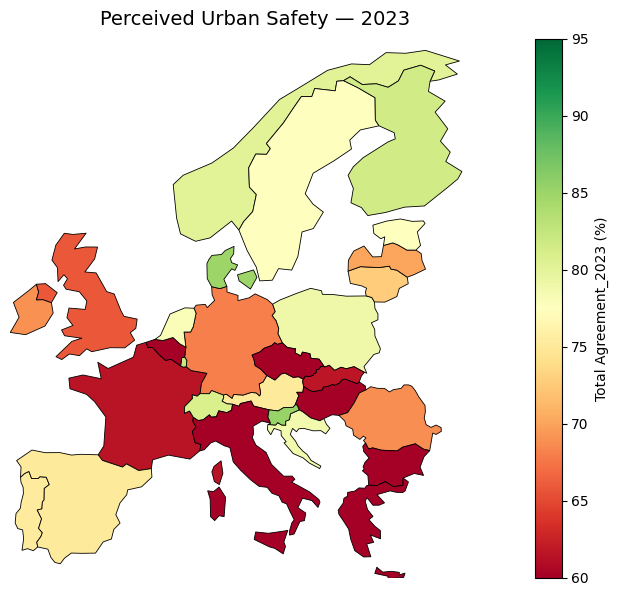

In [49]:
map_current(aggregate_by_country(percieved_safety), value_col="Total Agreement_2023")

## Further exploration

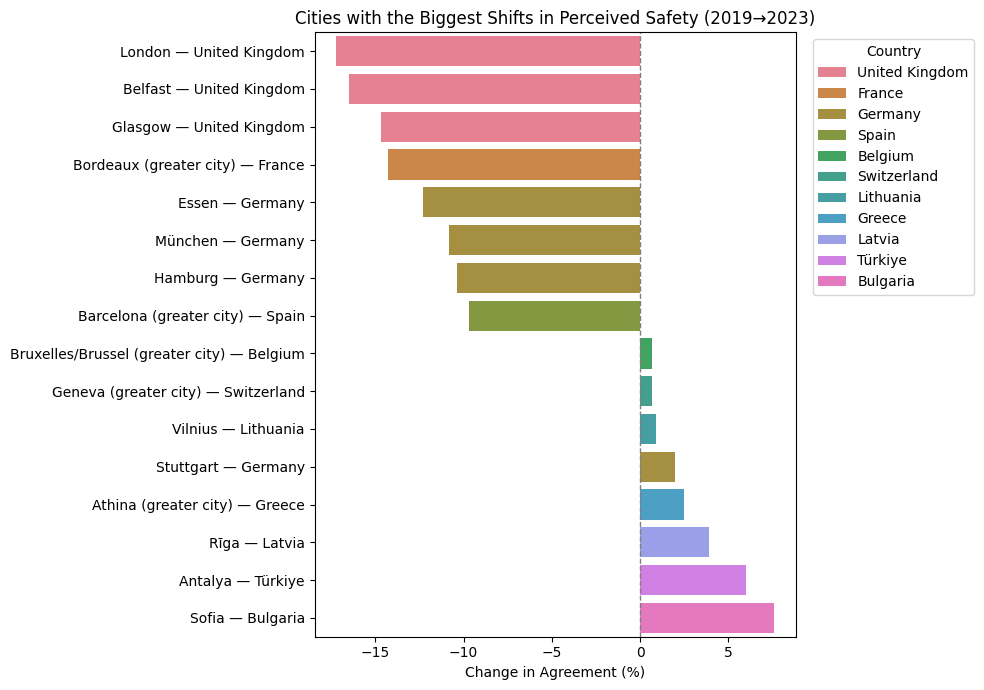

In [50]:
plot_city_extremes(percieved_safety, n=8)

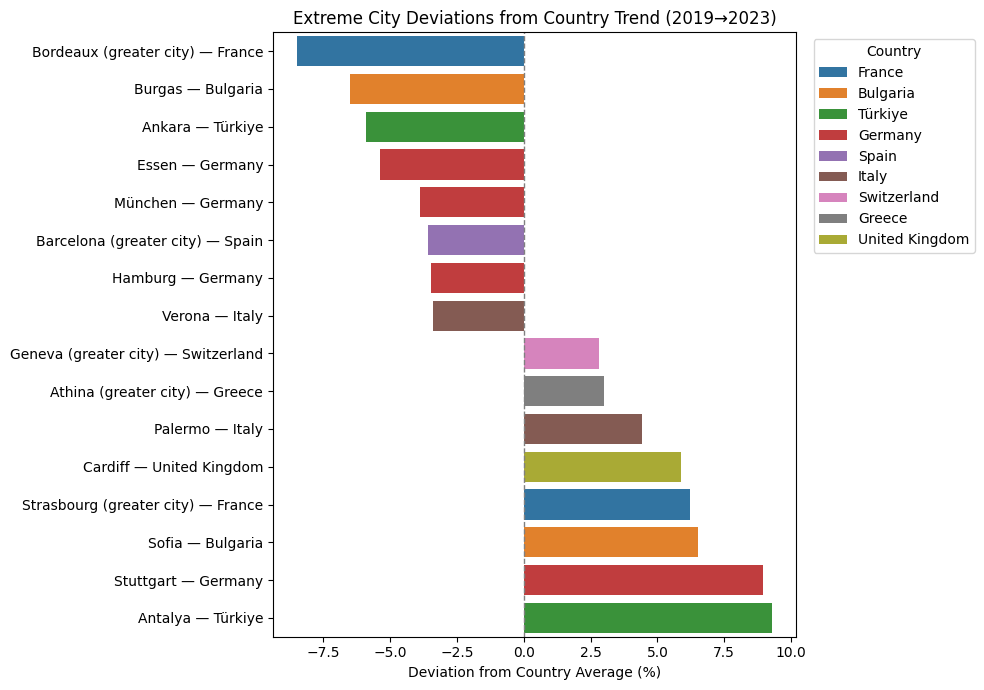

In [51]:
deviation_table = plot_extremes_vs_country(percieved_safety, n=8)

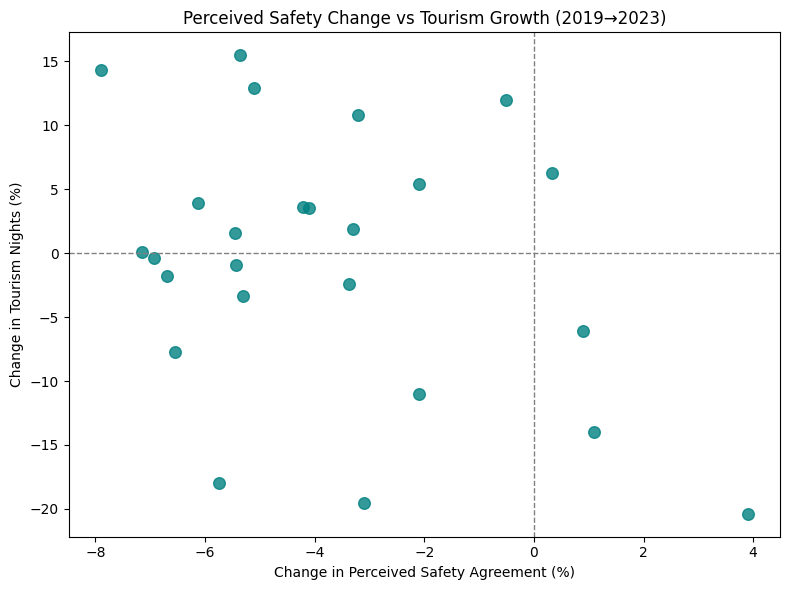

Pearson correlation: -0.34  (n=26)


In [52]:
annual_iso = load_tourism_annual_wide("tour_occ.tsv", years=(2019, 2023))
merged = plot_safety_vs_tourism(aggregate_by_country(percieved_safety), prepare_tourism_change(annual_iso))

slope=-0.098, intercept=-3.794, n=25


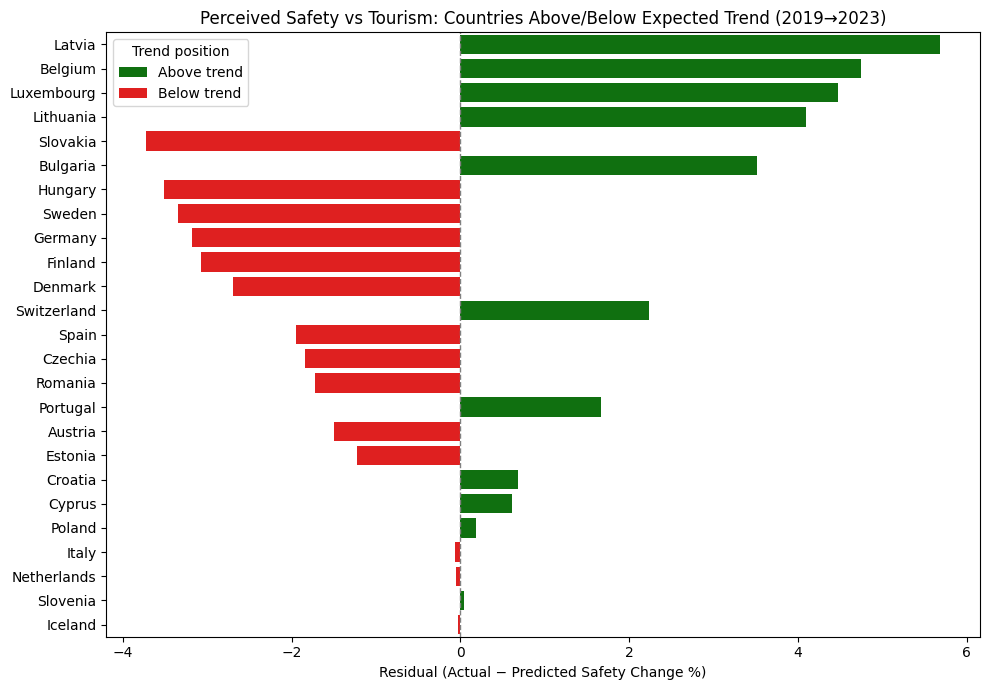

In [53]:
residuals = plot_safety_residuals(merged)

✅ Cleaned dataset: 25 rows
       Tourism Δ (%)  Change in Agreement
count      25.000000            25.000000
mean       -0.543058            -3.740833
std        10.284057             2.996129
min       -20.388403            -7.900000
25%        -6.113390            -5.750000
50%         0.133479            -4.216667
75%         5.453736            -2.100000
max        15.487705             3.900000
slope = -0.0984, intercept = -3.7943, n = 25


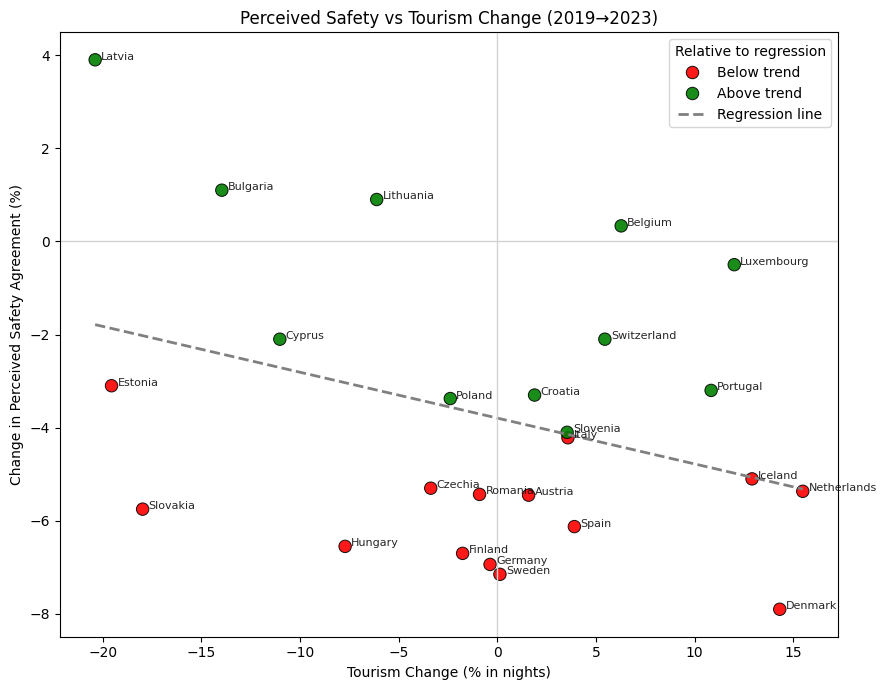

In [54]:
scatter_data = plot_safety_vs_tourism_scatter(merged, label_top_n=25)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37c198e5-2d9d-4d28-8044-4b6f490ea356' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>